In [104]:
import warnings, requests, zipfile, io 
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import os
import boto3
import sagemaker
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sagemaker.image_uris import retrieve
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression

In [105]:
# Specify the path to the ZIP file and the extraction directory
zip_file_path = 'food-twentieth-century-crop-statistics-1900-2017-xlsx.zip'  # Replace with the actual path to your ZIP file
extraction_path = './data'  # Specify the directory where you want to extract the contents

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# List the files in the extraction directory to see the extracted files
extracted_files = os.listdir(extraction_path)
print("Extracted files:", extracted_files)

# Assuming you want to read the first Excel file in the extraction directory
#excel_file_path = os.path.join(extraction_path, extracted_files[0])
#df = pd.read_excel(excel_file_path)

# Now, 'df' contains your data as a DataFrame that you can work with.

Extracted files: ['food-twentieth-century-crop-statistics-1900-2017-documentation.pdf', 'food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx']


In [106]:
# Load the Excel file
file = pd.ExcelFile("data/food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx")

# Read data from a specific sheet (e.g., 'CropStats')
sheet_name = 'CropStats'  # Replace with the name of the sheet you want to load
df = file.parse(sheet_name)

# Set the index to the first column and remove the index name
df = df.set_index(df.columns[0])
df.index.name = None

# Now, 'df' contains the data from the specified sheet with the index set as described.


In [107]:
df.head()

,Harvest_year,admin0,admin1,crop,hectares (ha),production (tonnes),year,yield(tonnes/ha),admin2,notes
0,1902,Austria,NaN,wheat,NaN,NaN,1902,1.31,NaN,NaN
1,1903,Austria,NaN,wheat,NaN,NaN,1903,1.47,NaN,NaN
2,1904,Austria,NaN,wheat,NaN,NaN,1904,1.27,NaN,NaN
3,1905,Austria,NaN,wheat,NaN,NaN,1905,1.33,NaN,NaN
4,1906,Austria,NaN,wheat,NaN,NaN,1906,1.28,NaN,NaN


In [108]:
#cleaning
df.drop(['admin2', 'notes'], axis=1, inplace=True)
df.rename(columns = {'admin0': 'national', 'admin1': 'subnational', 'hectares (ha)': 'hectares_ha', 'production (tonnes)': 'production_tonnes', 'yield(tonnes/ha)': 'yield_tonnes_ha'}, inplace=True)
df.loc[df['subnational'].isna(), 'subnational'] = df['national']

mask = df['yield_tonnes_ha'].isna() & ~df['production_tonnes'].isna() & ~df['hectares_ha'].isna() & df['hectares_ha'] != 0
df.loc[mask, 'yield_tonnes_ha'] = df['production_tonnes'] / df['hectares_ha']
df.dropna(subset=['yield_tonnes_ha'], inplace=True)
len(df[~pd.isnull(df['hectares_ha']) & pd.isnull(df['production_tonnes']) & ~pd.isnull(df['yield_tonnes_ha'])])
# The mask is used here because of I did the same way as above it kept timing out
mask = df['production_tonnes'].isna() & ~df['yield_tonnes_ha'].isna() & ~df['hectares_ha'].isna()
df.loc[mask, 'production_tonnes'] = df['yield_tonnes_ha'] * df['hectares_ha']
df.dropna(subset=['production_tonnes'], inplace=True)
mask = df['hectares_ha'].isna() & ~df['yield_tonnes_ha'].isna() & ~df['production_tonnes'].isna()
df.loc[mask, 'hectares_ha'] = df['yield_tonnes_ha'] * df['production_tonnes']
df.dropna(subset=['hectares_ha'], inplace=True)
# The columns we just adapted just changed into objects, let's make them floats again
df['hectares_ha'] = df['hectares_ha'].astype(float)
df['production_tonnes'] = df['production_tonnes'].astype(float)
df['yield_tonnes_ha'] = df['yield_tonnes_ha'].astype(float)
df['log_yield'] = np.log1p(df['yield_tonnes_ha'])
df['log_hectares'] = np.log1p(df['hectares_ha'])
df['log_production'] = np.log1p(df['production_tonnes'])

In [109]:
new_order = ['yield_tonnes_ha', 'national', 'subnational', 'crop', 'hectares_ha', 'log_hectares', 'production_tonnes', 'log_production', 'log_yield', 'Harvest_year']
df = df[new_order]

In [110]:
#data sample
df.shape
df.head(20)

,yield_tonnes_ha,national,subnational,crop,hectares_ha,log_hectares,production_tonnes,log_production,log_yield,Harvest_year
59,2.580000,Austria,Austria,wheat,275822.0,12.527515,7.116208e+05,13.475302,1.275363,1961
60,2.612000,Austria,Austria,wheat,270351.0,12.507480,7.061568e+05,13.467594,1.284262,1962
61,2.510000,Austria,Austria,wheat,274722.0,12.523519,6.895522e+05,13.443799,1.255616,1963
62,2.652000,Austria,Austria,wheat,282967.0,12.553089,7.504285e+05,13.528401,1.295275,1964
63,2.397000,Austria,Austria,wheat,275654.0,12.526905,6.607426e+05,13.401121,1.222893,1965
64,2.858000,Austria,Austria,wheat,313812.0,12.656553,8.968747e+05,13.706673,1.350149,1966
65,3.305000,Austria,Austria,wheat,316319.0,12.664510,1.045434e+06,13.859944,1.459777,1967
66,3.417000,Austria,Austria,wheat,305691.0,12.630333,1.044546e+06,13.859094,1.485461,1968
67,3.317000,Austria,Austria,wheat,286470.0,12.565393,9.502210e+05,13.764451,1.462561,1969
68,2.959999,Austria,Austria,wheat,275229.0,12.525362,8.146775e+05,13.610549,1.376244,1970


In [111]:
#train and validate model
train, test_and_validate = train_test_split(df, 
                                            test_size=0.2, 
                                            random_state=20) 
                                            #stratify=df['yield_tonnes_ha'])

In [112]:
#test and validate model
test, validate = train_test_split(test_and_validate, 
                                  test_size=0.5, 
                                  random_state=20)
                                 #stratify=df['yield(tonnes/ha)'])

In [113]:
print(train.shape)
print(test.shape)
print(validate.shape)

t1 = train['yield_tonnes_ha'].value_counts()
t2 = test['yield_tonnes_ha'].value_counts()
t3 = validate['yield_tonnes_ha'].value_counts()
result = pd.concat([t1,t2,t3], axis=1, sort=False)
result

(27324, 10)
(3415, 10)
(3416, 10)


,count,count,count
yield_tonnes_ha,,,
1.210527,163.0,23.0,19.0
1.277778,163.0,15.0,18.0
1.345030,161.0,22.0,18.0
1.076024,142.0,19.0,26.0
1.143275,139.0,15.0,26.0
...,...,...,...
1.764650,NaN,NaN,1.0
0.924000,NaN,NaN,1.0
2.591171,NaN,NaN,1.0


In [114]:
#upload to s3 bucket
bucket='c93435a2086654l5105130t1w6478590828-sandboxbucket-26l6r8c9sh60'
prefix='mod03-demo-training-a-model'
train_file='crop_train.csv'
test_file='crop_test.csv'
validate_file='crop_validate.csv'
whole_file='crop.csv'
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [115]:
role=sagemaker.get_execution_role()
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


In [116]:
hyperparams={
    "num_round":"20",
    "num_class":"7",
    "objective":"multi:softmax"}

In [117]:
xgb_model=sagemaker.estimator.Estimator(container,
                                        role,
                                        instance_count=1,
                                        instance_type='ml.m4.xlarge',
                                        output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [118]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

<Axes: >

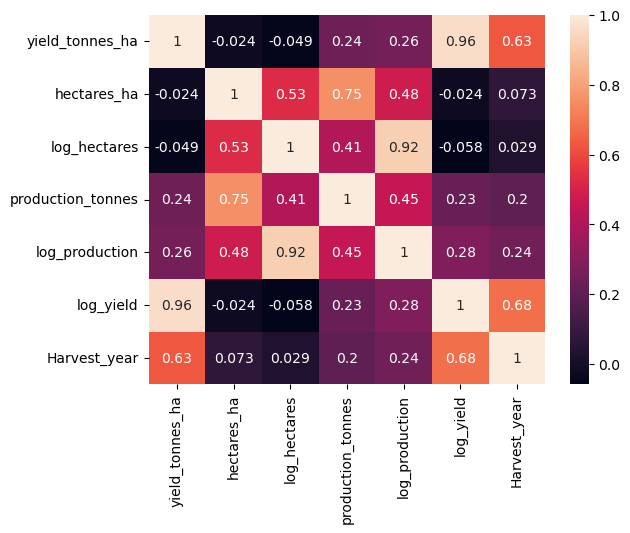

In [119]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True)

In [120]:
# Cunfusion matrix
test_labels = df.iloc[:,0]
df_wheat = df['crop'] == 'wheat'

matrix = confusion_matrix(test_labels, df_wheat)
df_confusion = pd.DataFrame(matrix, index=['Predicted Positive','Predicted Negative'],columns=['Actual Positive','Actual Negative'])

# Convert regression values to binary classes based on a threshold
threshold = 2.5
predicted_classes = (df['yield_tonnes_ha'] >= threshold).astype(int)
test_labels = (test_labels >= threshold).astype(int)

# Now, you can create a confusion matrix
matrix = confusion_matrix(test_labels, predicted_classes)

colormap = sns.color_palette("colorblind")
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [ ]:
# Create a LinearRegression object
lr = LinearRegression()

# Fit the model to the training data
lr.fit(train[['hectares_ha', 'production_tonnes']], train['yield_tonnes_ha'])

# Make predictions on the test data
test_predictions = lr.predict(test[['hectares_ha', 'production_tonnes']])

# Calculate the mean squared error (MSE) on the test data
mse = np.mean((test_predictions - test['yield_tonnes_ha'])**2)

# Print the MSE
print('MSE:', mse)

In [ ]:
#input channels
#xgb_model.fit(inputs=data_channels, logs=False)
xgb_model.fit(train[['yield_tonnes_ha', 'production_tonnes']], train['yield_tonnes_ha'])

In [ ]:
s=sagemaker.analytics.TrainingJobAnalytics(xgb_model._current_job_name, 
                                         metric_names = ['train:merror', 
                                                         'validation:merror']
                                        )

s_df=s.dataframe()
s_df = s_df.iloc[:,1:12]
s_df
#(wrong cases)/#(all cases)

In [ ]:
#df.drop(['national', 'subnational', 'crop'], axis=1, inplace=True)

ADF Statistic: -8.8971989680423
p-value: 1.1980174350638588e-14
Data is stationary


NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


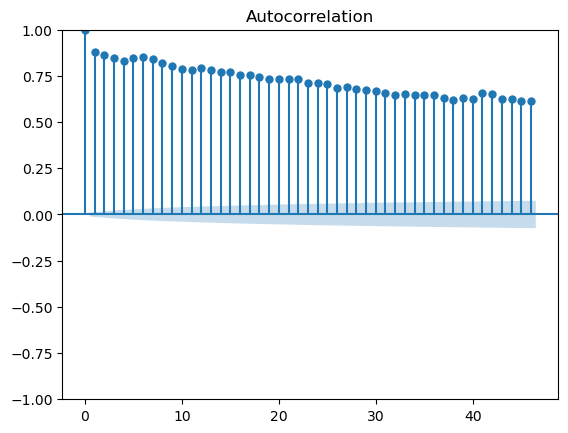

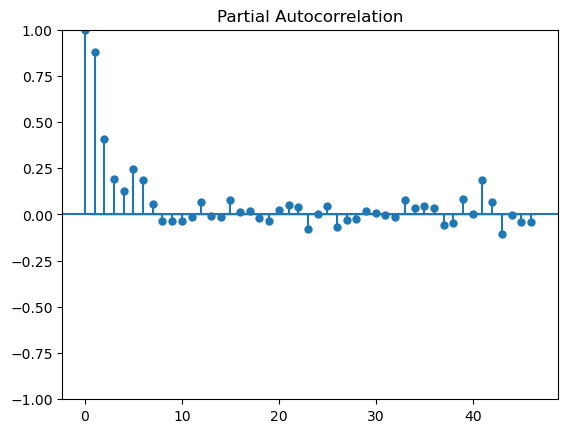

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



# Step 1: Load and explore your data
# Assuming you have a DataFrame called 'df' with a datetime index
# Example:
# df = pd.read_csv('your_time_series_data.csv', parse_dates=True, index_col='date_column')

# Step 2: Check for stationarity
result = adfuller(df['yield_tonnes_ha'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] <= 0.05:
    print('Data is stationary')
else:
    print('Data is not stationary')

# Step 3: Differencing (if needed)
df['yield_tonnes_ha'] = pd.to_numeric(df['yield_tonnes_ha'], errors='coerce')
df_diff = df['yield_tonnes_ha'].diff().dropna()

# Step 4: Plot ACF and PACF
plot_acf(df['yield_tonnes_ha'])
plot_pacf(df['yield_tonnes_ha'])

# Step 5: Build and train the ARIMA model
p, d, q = 1, 1, 1  # Adjust these values based on ACF and PACF plots
model = ARIMA(df_diff, order=(p, d, q))
results = model.fit()

# Step 6: Model evaluation (optional)
# Use metrics like MAE, MSE, RMSE to evaluate the model

# Step 7: Forecasting
forecast = results.forecast(steps=n)  # Replace 'n' with the number of periods to forecast
forecast = pd.Series(forecast, index=df_diff.index[-n:])  # Assuming you want to add the forecasts to your DataFrame

# Plot the original data and forecasts
plt.figure(figsize=(12, 6))
plt.plot(df['yield_tonnes_ha'], label='Original Data')
plt.plot(forecast, label='Forecasted Data', color='red')
plt.legend()
plt.show()